In [44]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os
import random
from tqdm import tqdm
from transformers import ViTConfig, ViTForImageClassification

In [2]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)

seed_everything(42)

In [3]:
os.chdir('C:\\Users\\Daniel\\Desktop\\Grad school\\UWaterloo Masters\\Winter 2024\\STAT923\\Final Project\\STAT932_Final_Project\\Images')
data = pd.read_csv('data.csv')
data.head()

images  labels
0  20130529_01_Driv_001_f .jpg       0
1  20130529_01_Driv_002_f .jpg       0
2  20130529_01_Driv_003_f .jpg       0
3  20130529_01_Driv_004_f .jpg       0
4  20130529_01_Driv_005_f .jpg       0

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data['images'], data['labels'], 
                                                    test_size = 0.2, stratify= data['labels'],
                                                    random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(484,)
(484,)
(122,)
(122,)


In [57]:
def preproc_images(image_paths, label_images, target_size = (80,80)):
    images = []
    labels = []
    idx = 0
    for img_path in image_paths:
        with Image.open(img_path) as img:
            img_resized = img.resize(target_size)
            #img_gray = img_resized.convert('L')
            img_array = np.array(img_resized) / 255.0
            images.append(img_array)
            labels.append(label_images[idx])
        idx += 1
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

os.chdir('C:\\Users\\Daniel\\Desktop\\Grad school\\UWaterloo Masters\\Winter 2024\\STAT923\\Final Project\\STAT932_Final_Project\\Images\\DrivImages')
train_images, train_labels = preproc_images(list(X_train), list(y_train), target_size = (224, 224))
test_images, test_labels = preproc_images(list(X_test), list(y_test), target_size = (224, 224))

In [58]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
)

labels_to_augment = [1, 2]

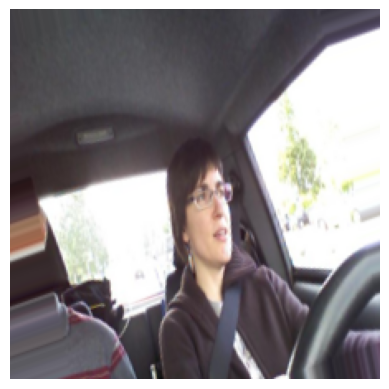

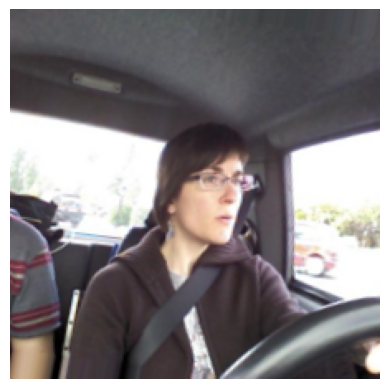

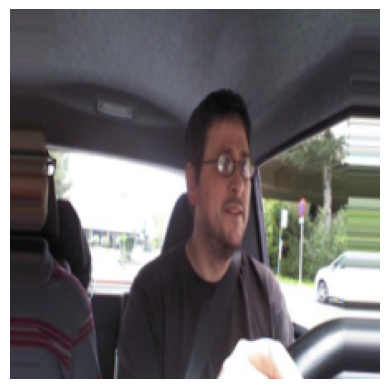

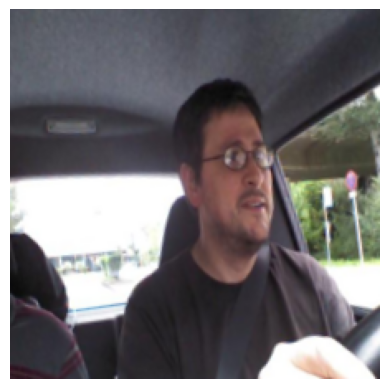

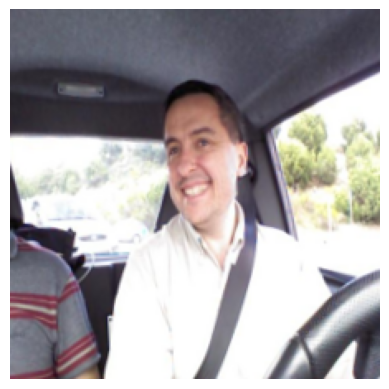

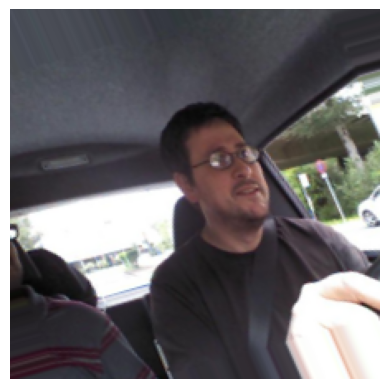

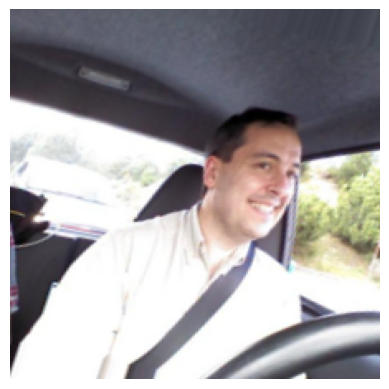

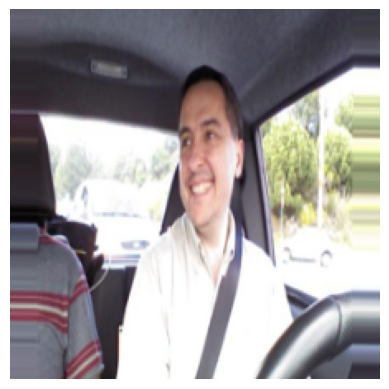

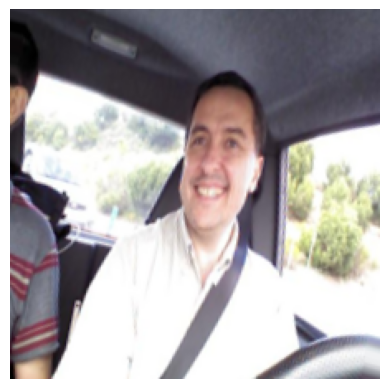

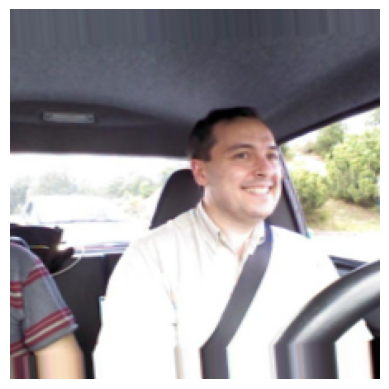

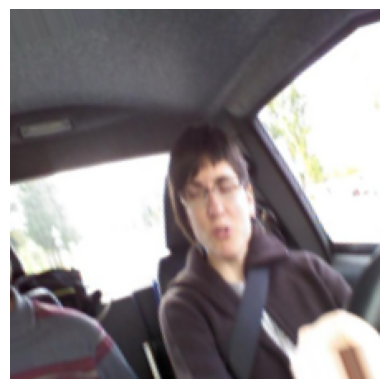

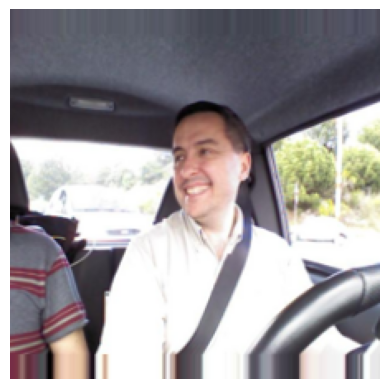

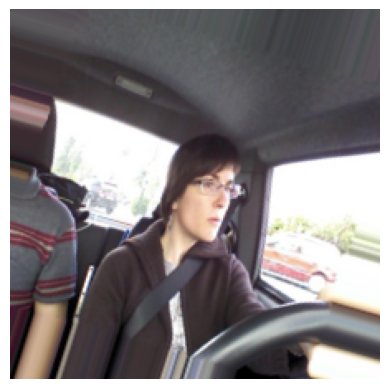

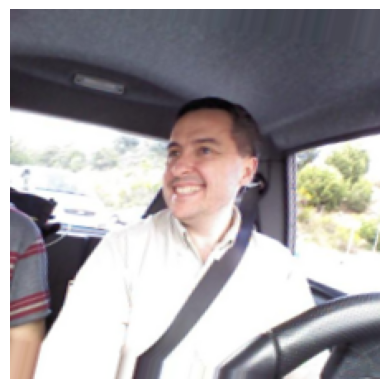

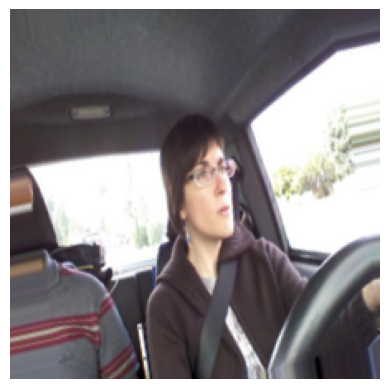

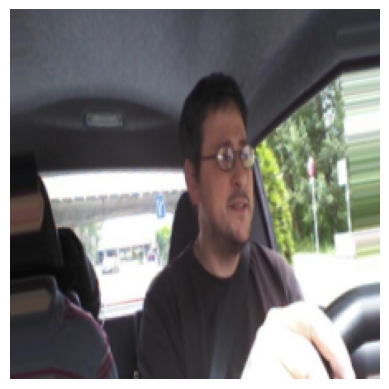

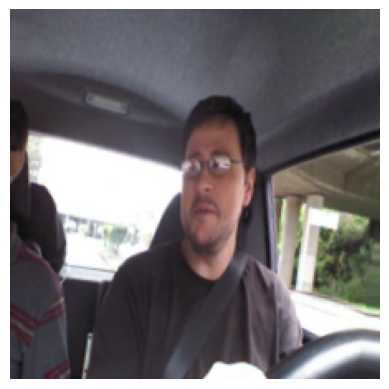

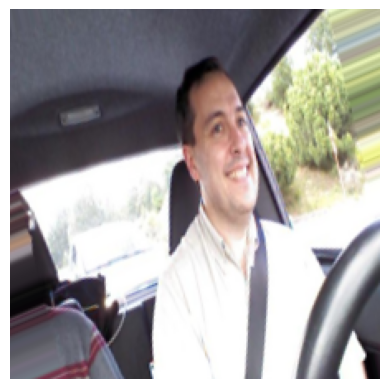

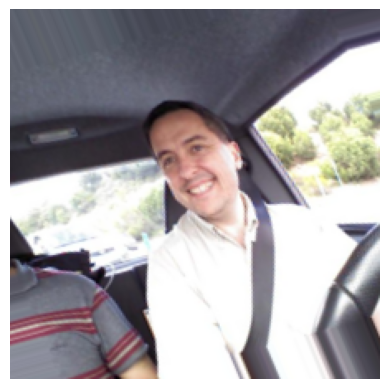

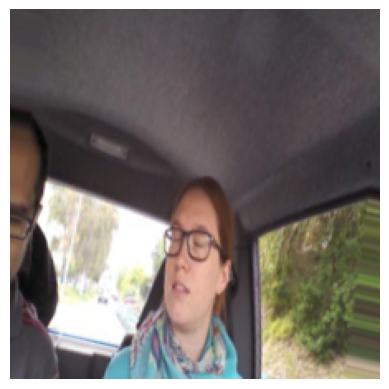

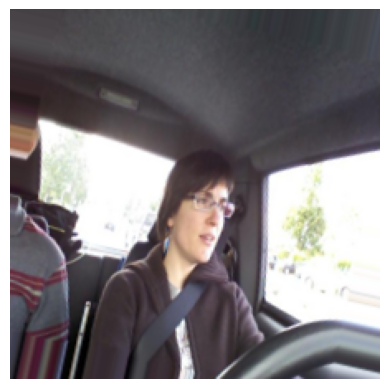

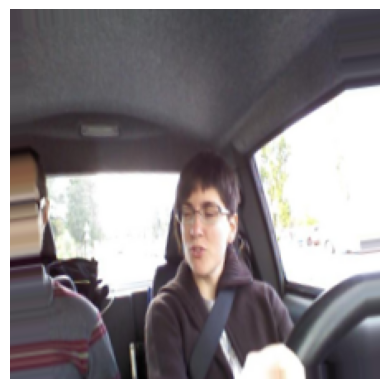

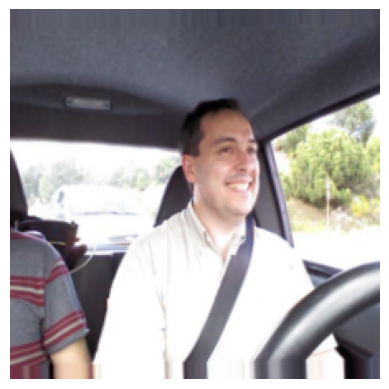

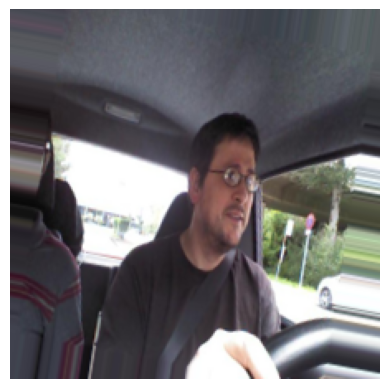

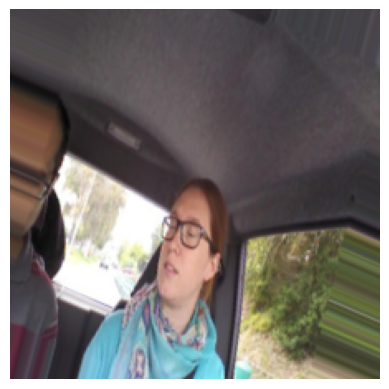

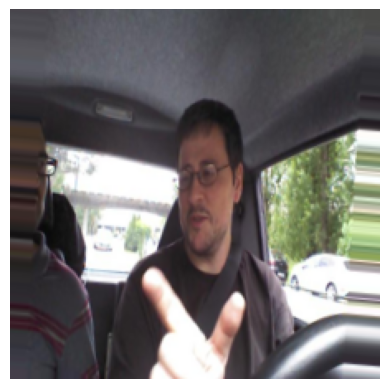

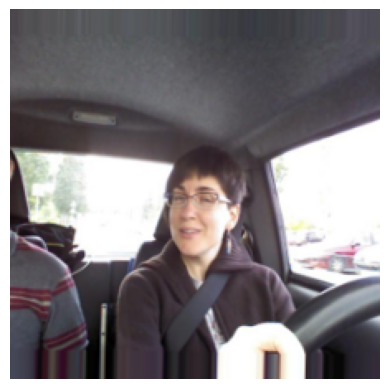

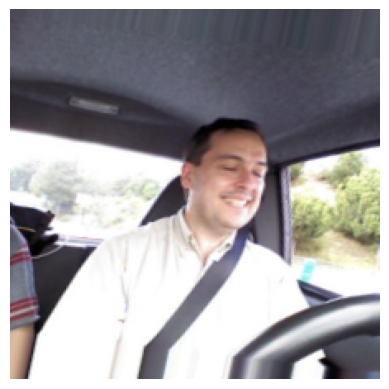

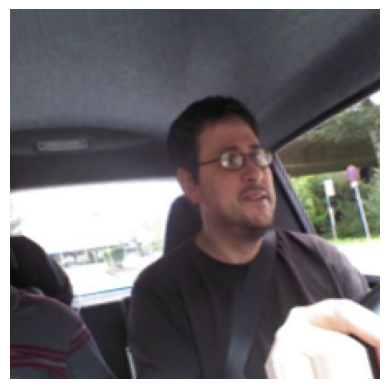

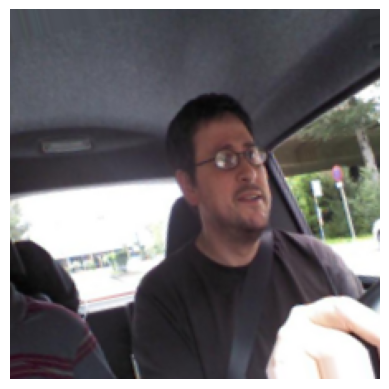

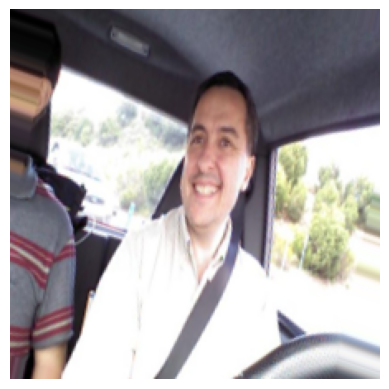

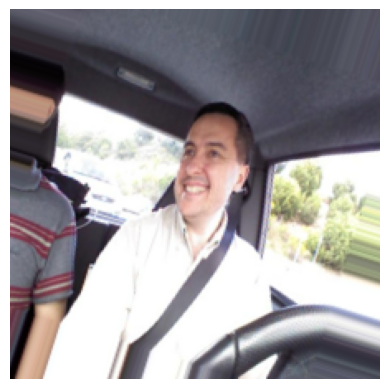

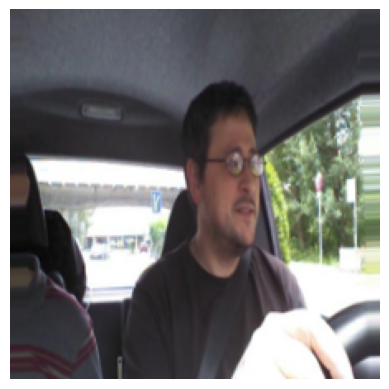

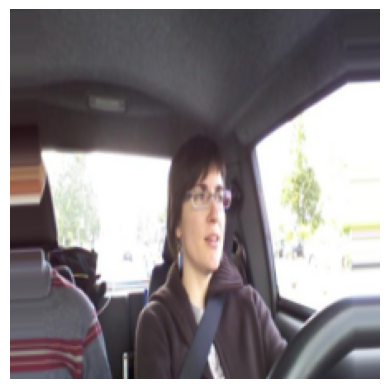

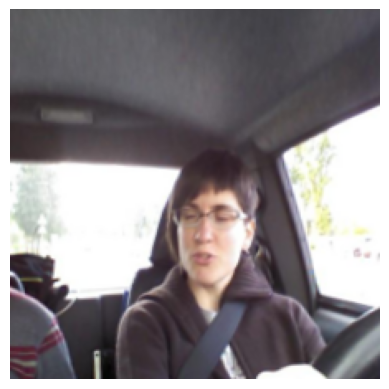

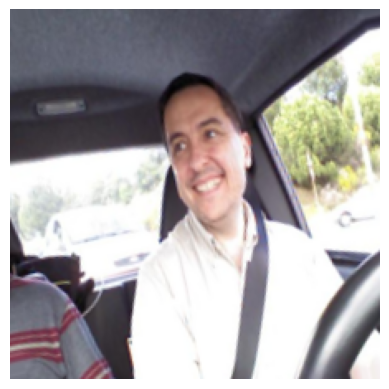

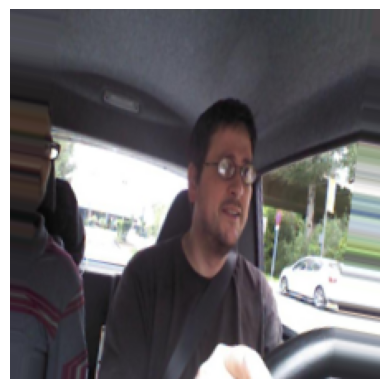

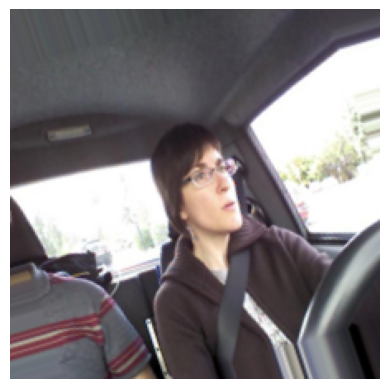

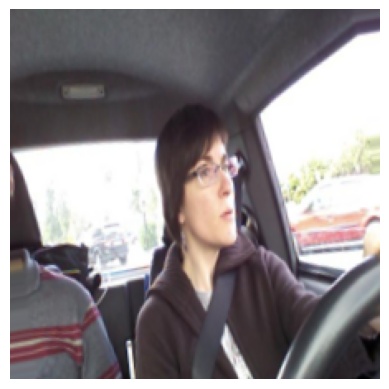

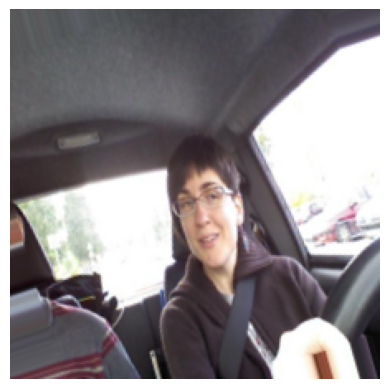

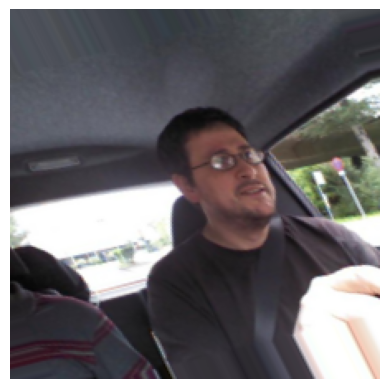

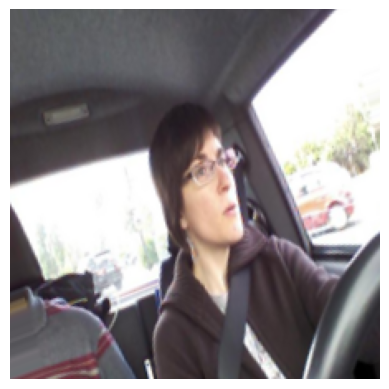

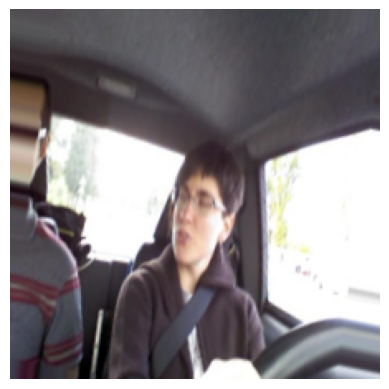

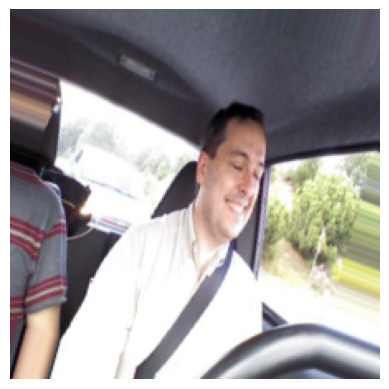

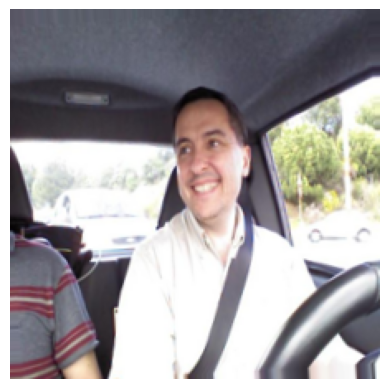

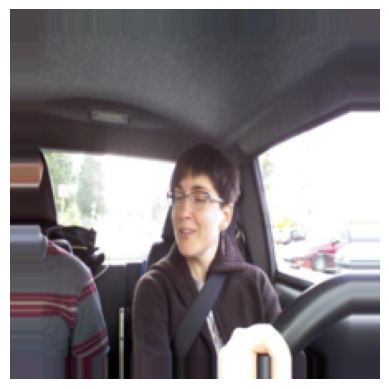

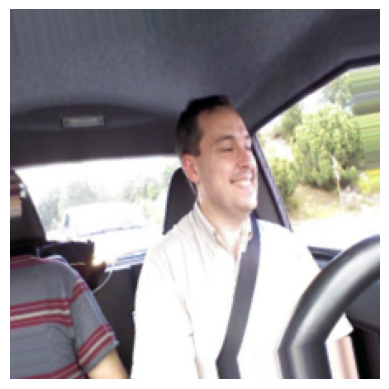

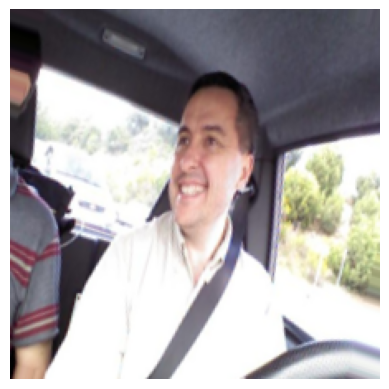

In [59]:
augmented_train_images = []
augmented_train_labels = []

augmentations_per_image = 18


for img, label in zip(train_images, train_labels):
    if label in labels_to_augment:
        img = img.reshape((1,) + img.shape)
        idx = 0
        augment = data_gen.flow(img, batch_size = 1)
        for batch in augment:
            augmented_image = batch[0]
            augmented_train_images.append(augmented_image)
            augmented_train_labels.append(label)
            idx += 1

            if idx == 5:
                plt.imshow(augmented_image, cmap='gray')
                plt.axis('off') 
                plt.show()

            if idx >= augmentations_per_image:
                break
            
    else:
        augmented_train_images.append(img)
        augmented_train_labels.append(label)


augmented_train_images = np.array(augmented_train_images)
augmented_train_labels = np.array(augmented_train_labels)

In [60]:
augmented_train_images_reshaped = augmented_train_images.reshape(augmented_train_images.shape[0], -1)
test_images_reshaped = test_images.reshape(test_images.shape[0], -1)
print(augmented_train_images_reshaped.shape)
print(test_images_reshaped.shape)

(1300, 150528)
(122, 150528)


We can define our data loader this time for CNN, so the images, instead of being in the dimension of (n, h x w x c), where h is height, w is width, c is number of channels, the images will be in the form of (n, c,h, w)

In [61]:
class ImageDataset(Dataset):
    def __init__(self, image_data, label_data, transform=None):
        self.image_data = image_data
        self.label_data = label_data
        self.transform = transform

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        feature_row = self.image_data[idx,]
        label_row = self.label_data[idx,]

        h = 224
        w = 224
        num_channels = 3
    
        image  = torch.tensor(feature_row, dtype = torch.float)
        label = torch.tensor(label_row, dtype = torch.long)
        image = image.reshape(num_channels, h,w)

        if self.transform:
            image = self.transform(image)

        return image, label

In [62]:
train_dataset = ImageDataset(image_data= augmented_train_images_reshaped, label_data = augmented_train_labels)
test_dataset = ImageDataset(image_data = test_images_reshaped, label_data = test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

We can leverage Torch's implementation of ResNet

In [63]:
os.environ['CUDA'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [64]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [65]:
#config = ViTConfig(image_size = 80, num_labels = 3) 

model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
#model = ViTForImageClassification(config)
#model.config
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

In [68]:
vit_wts_path = "C:\\Users\\Daniel\\Desktop\\Grad school\\UWaterloo Masters\\Winter 2024\\STAT923\\Final Project\\STAT932_Final_Project\\Transformers\\VIT_checkpoint_saved.pt"
early_stopping = EarlyStopping(patience=10, verbose=True, path = vit_wts_path)

num_epochs = 100
for epoch in range(100):
    model.train()
    total_loss = 0.0
    test_loss = 0.0

    for image, labels in tqdm(train_loader):
        image = image.cuda().to(device)
        labels = labels.cuda().to(device)

        optimizer.zero_grad()

        outputs = model(image)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda().to(device)
            labels = labels.cuda().to(device)

            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            test_loss += loss.item()
        
    test_loss /= len(test_loader)
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    print(f'Epoch [{epoch+1}/{100}], Loss: {total_loss/len(train_loader):.4f}')

100%|██████████| 163/163 [23:00<00:00,  8.47s/it]


Validation loss decreased (inf --> 1.576969). Saving model...
Epoch [1/100], Loss: 1.3242


100%|██████████| 163/163 [19:31<00:00,  7.19s/it]


Validation loss decreased (1.576969 --> 1.111648). Saving model...
Epoch [2/100], Loss: 1.1490


100%|██████████| 163/163 [23:39<00:00,  8.71s/it]


Validation loss decreased (1.111648 --> 1.040250). Saving model...
Epoch [3/100], Loss: 1.2095


100%|██████████| 163/163 [51:20<00:00, 18.90s/it]  


Validation loss decreased (1.040250 --> 0.921278). Saving model...
Epoch [4/100], Loss: 1.1385


100%|██████████| 163/163 [12:17<00:00,  4.53s/it]


EarlyStopping counter: 1 out of 10
Epoch [5/100], Loss: 1.1224


100%|██████████| 163/163 [17:53<00:00,  6.58s/it]


EarlyStopping counter: 2 out of 10
Epoch [6/100], Loss: 1.1296


100%|██████████| 163/163 [13:57<00:00,  5.14s/it]


EarlyStopping counter: 3 out of 10
Epoch [7/100], Loss: 1.1189


100%|██████████| 163/163 [15:06<00:00,  5.56s/it]


Validation loss decreased (0.921278 --> 0.823336). Saving model...
Epoch [8/100], Loss: 1.1182


100%|██████████| 163/163 [15:32<00:00,  5.72s/it]


EarlyStopping counter: 1 out of 10
Epoch [9/100], Loss: 1.1034


100%|██████████| 163/163 [15:04<00:00,  5.55s/it]


EarlyStopping counter: 2 out of 10
Epoch [10/100], Loss: 1.1122


100%|██████████| 163/163 [18:08<00:00,  6.68s/it]


EarlyStopping counter: 3 out of 10
Epoch [11/100], Loss: 1.1021


100%|██████████| 163/163 [13:08<00:00,  4.84s/it]


EarlyStopping counter: 4 out of 10
Epoch [12/100], Loss: 1.1078


100%|██████████| 163/163 [10:57<00:00,  4.03s/it]


EarlyStopping counter: 5 out of 10
Epoch [13/100], Loss: 1.0998


100%|██████████| 163/163 [07:01<00:00,  2.59s/it]


EarlyStopping counter: 6 out of 10
Epoch [14/100], Loss: 1.1019


100%|██████████| 163/163 [07:01<00:00,  2.59s/it]


EarlyStopping counter: 7 out of 10
Epoch [15/100], Loss: 1.0995


100%|██████████| 163/163 [07:01<00:00,  2.59s/it]


EarlyStopping counter: 8 out of 10
Epoch [16/100], Loss: 1.0910


100%|██████████| 163/163 [07:01<00:00,  2.59s/it]


EarlyStopping counter: 9 out of 10
Epoch [17/100], Loss: 1.1017


100%|██████████| 163/163 [07:01<00:00,  2.59s/it]


EarlyStopping counter: 10 out of 10
Early stopping


In [54]:
# Loading best weight after experimentation
#vit_best_path = "C:\\Users\\Daniel\\Desktop\\Grad school\\UWaterloo Masters\\Winter 2024\\STAT923\\Final Project\\STAT932_Final_Project\\CNN\\Resnet18_checkpoint_saved.pt"
#model.load_state_dict(torch.load(vit_best_path))

In [69]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.cuda().to(device)
        labels = labels.cuda().to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total}%')

Accuracy of the network on the test images: 4.918032786885246%


We see that the ViT performed extremely poorly, failing to generalize. ViT performed poorly probably due to the large model size not being needed. 